<a href="https://colab.research.google.com/github/clairecoffey/project/blob/master/claire_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness and the Bias/Variance Tradeoff

## Claire Coffey

## 1st May 2020

In this notebook we are studying bias and variance errors in the context of recidivism data. 

## Imports and Setup

Imports: first import the relevant libraries used throughout. 

In [0]:
# imports
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np
import pandas as pd

# Read in recidivism data 

In this notebook we are studying recidivism data. We utilise the COMPAS recidivism dataset, which uses recidivism data from Broward County jail and has been explored in the following studies:

"The accuracy, fairness, and limits of predicting recidivism", paper available at:
https://advances.sciencemag.org/content/4/1/eaao5580#corresp-1

"Machine Bias" ProPublica article, available at:
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

The dataset used can be found at:
https://github.com/propublica/compas-analysis


Here we import and read in the recidivism data. 

Currently, we use a selection 
of fields from this dataset to predict recidivism classification (0 = will not reoffend; 1 = will reoffend).

In [0]:

def load_file():
  full_data = False
  print("importing data")
  if full_data:
    # full dataset
    file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/compas-scores-two-years%20-%20compas-scores-two-years.csv?token=ABPC6VJE3BXQDQ25BHIL7DK6SWGT2"
  else:
    # small subset of first 500 people
    file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/500-compas-scores-two-years%20-%20Sheet1%20(1).csv?token=ABPC6VM4ZHOTALXKV3BIB2K6WVJ7Q"

  # load CSV contents
  all_data = pd.read_csv(file_path, delimiter=',', dtype={'sex': 'category', 
                                                          'age_cat': 'category',
                                                          'race': 'category',
                                                          'c_charge_degree': 'category',
                                                          'c_charge_desc': 'category',
                                                          'r_charge_degree': 'category',
                                                          'r_charge_desc': 'category',
                                                          'vr_charge_degree': 'category',
                                                          'vr_charge_desc': 'category'
                                                          })
  return all_data


In [0]:
all_data = load_file()

importing data


In [0]:
def import_data(all_data):

  #is get_dummies the best way to do this?
  encoded_sex = (pd.get_dummies(all_data['sex']))
  all_data = all_data.drop(columns=['sex'])
  all_data = all_data.join(encoded_sex)

  encoded_age_cat = (pd.get_dummies(all_data['age_cat']))
  all_data = all_data.drop(columns=['age_cat'])
  all_data = all_data.join(encoded_age_cat)

  encoded_race = (pd.get_dummies(all_data['race']))
  all_data = all_data.drop(columns=['race'])
  all_data = all_data.join(encoded_race)

  encoded_c_charge_desc = (pd.get_dummies(all_data['c_charge_degree']))
  all_data = all_data.drop(columns=['c_charge_degree'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_c')

  #these are joined with suffixes because otherwise columns overlap 
  encoded_c_charge_desc = (pd.get_dummies(all_data['c_charge_desc']))
  all_data = all_data.drop(columns=['c_charge_desc'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_c')

  encoded_c_charge_desc = (pd.get_dummies(all_data['r_charge_degree']))
  all_data = all_data.drop(columns=['r_charge_degree'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_r')

  encoded_r_charge_desc = (pd.get_dummies(all_data['r_charge_desc']))
  all_data = all_data.drop(columns=['r_charge_desc'])
  all_data = all_data.join(encoded_r_charge_desc, rsuffix='_r')

  encoded_c_charge_desc = (pd.get_dummies(all_data['vr_charge_degree']))
  all_data = all_data.drop(columns=['vr_charge_degree'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_vr')

  encoded_vr_charge_desc = (pd.get_dummies(all_data['vr_charge_desc']))
  all_data = all_data.drop(columns=['vr_charge_desc'])
  all_data = all_data.join(encoded_vr_charge_desc, rsuffix='_vr')

  #drop columns not used for predictions, including info such as names, and coluns with many NaN values 
  training_data = all_data.drop(columns=['two_year_recid', 'r_days_from_arrest', 'id','name','first','last','dob','days_b_screening_arrest','c_jail_in','c_jail_out','c_case_number','c_offense_date','c_arrest_date','r_case_number','r_offense_date','r_jail_in','r_jail_out','vr_case_number','vr_offense_date','in_custody','out_custody','start','end','violent_recid'])

  training_data_and_labels = training_data.join(all_data[['two_year_recid']])

  #need to handle NaN values
  #remove rows containing NaN values 
  training_data_and_labels = training_data_and_labels.dropna()

  #split into training and testing with specific number of testing samples
  #for now just set testing set to be first 50 samples in table 
  testing_data_and_labels = training_data_and_labels[:51]
  #and training set to be the remainder
  #this is also then consistent which is good for seeing patterns etc 
  training_data_and_labels = training_data_and_labels[51:]

  return training_data_and_labels, testing_data_and_labels

In [0]:
training_data_and_labels, testing_data_and_labels = import_data(all_data)

# Classification - choose model and perform predictions using bootstrapping

Here we select the classification model to use. We are using a selection of built-in classifiers in scikit-learn. (Currently, the parameters of the models are not optimal and are for testing purposes only. In order to select optimal parameters, a procedure such as grid search should be used.)

The classification process then uses a bootstrapping procedure with the chosen model, to generate predictions of recidivism classifications Bootstrapping is a sampling with replacement procedure. We use this to generate many classification predictions for the given dataset, by running bootstrapping many times to generate different training and testing datasets. The training and testing datasets are called the "boot" and "out of bag" examples respectively. 

In [0]:
from sklearn import model_selection, neighbors, svm, gaussian_process, tree, ensemble, neural_network, metrics

def define_classifiers():
    print("defining classifiers")
    # random classifiers to test
    classifier_names = ["RBF SVM"]

    classifiers = [
        svm.SVC(gamma=2, C=2),
        ]

    # choose classifier
    classifier = "RBF SVM"
    print("Classifer used: ", classifier)
    return classifier, classifiers, classifier_names


In [0]:
define_classifiers()

defining classifiers
Classifer used:  RBF SVM


('RBF SVM',
 [SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
      probability=False, random_state=None, shrinking=True, tol=0.001,
      verbose=False)],
 ['RBF SVM'])

In [0]:
def do_bootstrap(training_data_and_labels):
  #this is one bootstrap sample 
  #sample size is the same as the number of datapoints we have 
  indices = np.random.randint(0,training_data_and_labels.shape[0] , training_data_and_labels.shape[0])
  #do we need to sort it? makes it clearer anyway
  indices.sort()
  data_points = []
  out_of_bag_points = []
  for i in indices:
    data_points.append(training_data_and_labels.iloc[i])

  b_sample = pd.DataFrame(data_points)

  #need to find all of the datapoints not in the bootstrap sample  and add these to out of bag sample
  # out_of_bag = training_data_and_labels.merge(b_sample, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
  # out_of_bag = out_of_bag.drop(columns='_merge')

  return b_sample

In [0]:
b_sample = do_bootstrap(training_data_and_labels)

In [0]:
def classify(training_data_and_labels, testing_data_and_labels):
    classifier, classifiers, classifier_names = define_classifiers()
    clf = classifiers[classifier_names.index(classifier)]
    count = 0

    # predictions = pd.DataFrame()
    # true_labels = pd.DataFrame()

    num_bootstraps = len(training_data_and_labels);
    while count <= num_bootstraps:
      b_sample = do_bootstrap(training_data_and_labels)
      y_pred, y_true = fit_model(clf, b_sample, testing_data_and_labels)
      if(count == 0):
        predictions = pd.DataFrame(pd.Series(y_pred)).transpose()
        #true labels are the same for every sample so we only need 1 row in df
        true_labels = pd.DataFrame(pd.Series(y_true)).transpose()
      else:
        predictions = predictions.append(pd.DataFrame(pd.Series(y_pred)).transpose())
      count += 1
    return predictions, true_labels

In [0]:
def fit_model(clf, b_sample, testing_data_and_labels):

    #training data is everything apart from two year recid 0/1 label
    # model is fit on the boot sample and evaluated on the out-of-bag sample
    X_train = b_sample.drop(columns=['two_year_recid'])
    y_train = b_sample['two_year_recid']
    X_test = testing_data_and_labels.drop(columns=['two_year_recid'])
    y_test = testing_data_and_labels['two_year_recid']

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_true = y_test

    return y_pred, y_true

In [0]:
classify(training_data_and_labels, testing_data_and_labels)


defining classifiers
Classifer used:  RBF SVM


(    0   1   2   3   4   5   6   7   8   9   ...  41  42  43  44  45  46  47  48  49  50
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
 0    0   0   0   0  

# Compute bias/variance errors

Using all these bootstrap predictions, we calculate the average misclassification error, as described in this paper: 
http://www.cems.uwe.ac.uk/~irjohnso/coursenotes/uqc832/tr-bias.pdf

We can then decompose the error into the errors due to bias, and the errors due to variance, in order to study the behaviour of the model and the bias/variance tradeoff. This decomposition for classification is described in the following paper:
https://homes.cs.washington.edu/~pedrod/bvd.pdf

We define bias and variance in this context as in:
 http://www.cems.uwe.ac.uk/~irjohnso/coursenotes/uqc832/tr-bias.pdf

Currently, bias error is always ```0.0```, because the average misclassification error for each datapoint is ```<0.5```, so, on average, each datapoint is classified correctly, and the errors are therefore all due to variance. This is not the result wanted/expected. 

Perhaps we can use the mean squared error (as in https://pdfs.semanticscholar.org/9253/f3e13bca7e845e60394d85ddaec0d4cfc6d6.pdf), instead of misclassification error and results would be different. 

In [0]:
def compute_bias_variance(predictions, true_labels):

  print(predictions)
  #predictions is a dataframe, where each row contains is for each bootstrap training sample and
  # is a 0/1 classification prediction for each sample in the test set 
  #and each row  is for a bootstrap training sample 

  # calculate bias and variance for each datapoint using bootstrap samples
  # then we can use these to get the overall/avg across predictions
  biases = []
  variances = []
  avg_errors = []

  # calculate the bias and variance for each value of X,y
  # for misclassification loss

  #find whether each element is misclassified for each bootstrap sample 
  predictions_misclassified = predictions.apply(lambda x : x != true_labels.iloc[0], axis=1)
  print(predictions_misclassified)

  #count number of times misclassified for each datapoint across all bootstrap samples 
  counts = predictions_misclassified.apply(np.sum)
  print(counts)

  #average misclassification error for each individual/datapoint 
  avg_errors = counts.apply(lambda y : np.divide(y,len(predictions)))

  for avg_error in avg_errors:
    (bias, variance) = (0, avg_error) if (avg_error <= 0.5) else (1, (avg_error-1))
    biases.append(bias)
    variances.append(variance)

  avg_bias = np.mean(biases)
  #is this defo the right way to do variance?
  avg_var = abs(np.mean(avg_errors) - avg_bias)

  print(avg_bias)
  print(avg_var)

  return avg_bias, avg_var

# Plots

Plotting bias/variance errors for diff classifiers - just 1 at a time for now!

In [0]:
import matplotlib.pyplot as plt                                  
def plot_bias_variance(bias, variance):                                                                             
    plt.scatter(bias, variance)                                              
    plt.title('bias vs variance errors')                                     
    plt.xlabel('bias')                                                       
    plt.ylabel('variance')                                                   
    plt.show()                                                               
                                                                             

# Main method (execute code)

Main method to run the system


In [0]:
def main():
  all_data = load_file()
  training_data_and_labels, testing_data_and_labels = import_data(all_data)
  predictions, true_labels = classify(training_data_and_labels, testing_data_and_labels)  
  bias, variance = compute_bias_variance(predictions, true_labels)
  plot_bias_variance(bias, variance)


importing data
defining classifiers
Classifer used:  RBF SVM
    0   1   2   3   4   5   6   7   8   9   ...  41  42  43  44  45  46  47  48  49  50
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0
0    0   0   0   0   0   0   0   0   0   0  ...   0   0   0

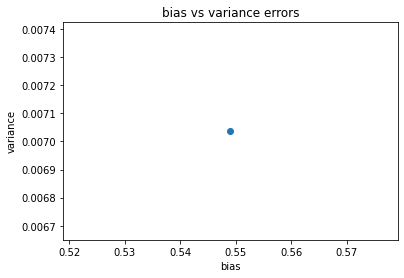

In [46]:
main()